We aim to solve the Lighthill-Withams-Richards PDE: u_t+u(1-u)_x = 0 on the domain x,t \in [0,2pi]x[0,3] with periodic boundary conditions.

Initial condition is a cubic spline interpolating 4 points u,x \in  [0.2,0.9]x[0,2pi]. The standard numerical solver (finite volume scheme) is used to solve for the solution.

Having solved numerically for 8 representative IC's, we import numerical solution to the problem in the form of LWRData-init-xval-tval.mat, an array whose i,j,k-th entry is the solution for (training) initial condition i, at x-value j, and time step k.

Here: 
0<i<8, indexes initial condition
0<j<512 indexes x-value with x_0=0.0123, x_511 = 2pi
0<k<513 indexes t-step with t_0 = 0, t_512 = 3

We aim to train a neural network to take input = u(t_n) (the solution at time n*\delta_t) and predict the solution u(t_{n+1}), (the solution at time (n+1)*\delta_t).

We will use a convolutional neural network architecture and activation function tanh.

for testing, we generate 8 new IC's, solve with the numerical solver and the model independently, then compare.

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init
import torch.nn.functional as F
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters 
input_size = 512 # u(<x>,t_i)

n_res_blocks = 1  #number of resblocks
output_size = 512
num_epochs = 20
learning_rate = 0.001
tmax= 3  #the maximum time forward which we predict 
dx = 2*np.pi/512
M = 513 #time steps
N = 512 #spacial points

In [130]:
# Define the neural network class
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # First Conv1D layer
        self.in_conv = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.tanh = nn.Tanh()

        # Second Conv1D layer
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3)
        

        # Output Conv1D layer
        self.out_conv = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=1)

    def forward(self, x):
        # Input shape: (batch_size, 1, 512) possibly outdated
        x= F.pad(x, (1, 1), mode='circular')
        x = self.in_conv(x)
        x = self.tanh(x)
        #Res block...
        y = x  #store original input to resblock
        x = F.pad(x, (1, 1), mode='circular')
        x = self.conv2(x)
        x = self.tanh(x)
        x = F.pad(x, (1, 1), mode='circular')
        x = self.conv2(x)
        x=x+y
        
        x = self.tanh(x)
        #end resblock

        x = self.out_conv(x)

        # Output shape: (batch_size, 1, 512)
        return x

# Create an instance of the model
net = MyCNN().to(device)


In [131]:
# Load the data
Dictdata = scipy.io.loadmat('C:/Users/thoma/Downloads/LWRData-init-xval-tval.mat')
Data = Dictdata['Data']
inputs = np.ndarray((4096, 1, 512))  # Reshape input data to have 1 channel
target_outputs = np.ndarray((4096, 1, 512))  # Reshape target output data

index = 0
for i in range(0, 8):
    for k in range(1, 513):
        inputs[index, 0, :] = Data[i, :, k - 1]
        target_outputs[index, 0, :] = Data[i, :, k]
        index = index + 1

inputs = torch.tensor(inputs, dtype=torch.float32, requires_grad=True).to(device)
target_outputs = torch.tensor(target_outputs, dtype=torch.float32, requires_grad=True).to(device)

batch_size = 64
dataset = TensorDataset(inputs, target_outputs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [132]:
#here be padding testing...
testttt = 1
for batch_input, batch_output in dataloader:
    if testttt == 1:
        
        print(net(batch_input).shape)
    testttt = 2


torch.Size([64, 1, 512])


In [133]:

# Define the loss function (replace with your actual loss function)
criterion = nn.MSELoss()

# Define the optimizer (e.g., Adam)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

num_epochs = 100

for epoch in range(num_epochs):
    for batch_input, batch_output in dataloader:
        # Move batch data to the GPU
        batch_input, batch_output = batch_input.to(device), batch_output.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        predictions = net(batch_input)

        # Compute the loss
        loss = criterion(predictions, batch_output)

        # Backpropagation and optimization
        
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    if (epoch+1)%50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Optionally, save the trained model
#torch.save(net.state_dict(), 'my_model.pth')

Epoch [50/100], Loss: 4.7924013415467925e-06
Epoch [100/100], Loss: 1.4464776540989988e-06


In [134]:
#Final predictions for training data...
predictions = net(inputs).to('cpu').detach().numpy()
#Load the TEST data (consists of 8 unseen solutions)
tDictdata = scipy.io.loadmat('C:/Users/thoma/Downloads/LWRData-init-xval-tvalTEST.mat')
tData = tDictdata['Data']
tinputs = np.ndarray((4096,1,512)) #nth row contains a solution at time t
ttarget_outputs = np.ndarray((4096,1,512)) #nth row contains corresponding solution at time t+1
index = 0
for i in range(0,8):
    for k in range(1,513):
        tinputs[index,0,:] = tData[i,:,k-1]
        ttarget_outputs[index,0,:] = tData[i,:,k]
        index = index+1
        
tinputs = torch.tensor(tinputs,dtype=torch.float32, requires_grad=True).to(device) 
ttarget_outputs = torch.tensor(ttarget_outputs,dtype=torch.float32, requires_grad=True).to(device)
#Final predictions for the test data
tpredictions = net(tinputs).to('cpu').detach().numpy()

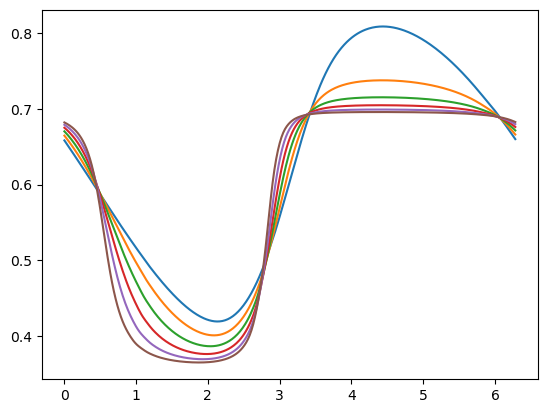

In [156]:
sample_input = torch.from_numpy(tpredictions[2200]).unsqueeze(1)
sample_input = sample_input.requires_grad_().to(device)
sample_output = net(sample_input)
for i in range(300):
    sample_output = net(sample_output)
    if i%50 == 0:
        plt.plot(x_values, sample_output.to('cpu').detach().numpy()[0,0,:])
plt.show()

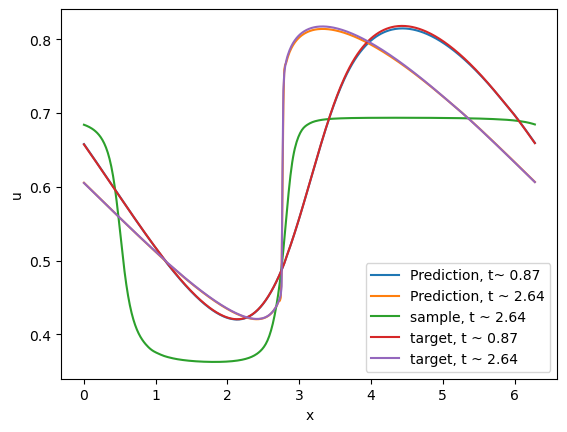

In [154]:
# Create a plot
x_values = np.linspace(0, 2 * np.pi, len(ttarget_outputs[1,0,:]))

plt.plot(x_values, tpredictions[2200,0,:], label='Prediction, t~ 0.87')
plt.plot(x_values, tpredictions[2500,0,:], label='Prediction, t ~ 2.64')
plt.plot(x_values, sample_output.to('cpu').detach().numpy()[0,0,:], label='sample, t ~ 2.64')
plt.plot(x_values, ttarget_outputs.to('cpu').detach().numpy()[2200,0,:], label='target, t ~ 0.87')
plt.plot(x_values, ttarget_outputs.to('cpu').detach().numpy()[2500,0,:], label='target, t ~ 2.64')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('u')
plt.legend()

# Show the plot
plt.show()

Final notes: 
This looks fantastic! But I am wary... The model is trained to take input at time t_n and output at time t_n+1. Is it possible that the network has learned to output NN(u(t)) = u(t)? This would produce a result close to u(t_n+1) by nature of small time step differences being close to one another.

What should be tested is repeated application of neural net, i.e. is n fold application of neural net,
NN(NN(NN(...(u(0))...) = u(t_n)???

EDIT: implemented padding in order to apply network successively. final output marked 'sample' applies neural net 300 times to target(t=0.87). The result is very poor!

Next: change the loss function to reflect numerical scheme.